# Final Project for INFO 6350
### Project Team: Yun Zhou (yz2685)

# Part 0: Background

**Statement of the problem:** A 10-K report is a comprehensive report filed annually by a publicly traded company to the U.S. Securities and Exchange Commission (SEC) regarding the company's financial performance and business operations of the last fiscal year. Almost every 10-K report includes content like business overview, industry overview, risk factors, competition, financial statements, income statements, and so on. In the past few years, those reports have been getting more and more in terms of page numbers and word counts. For example, General Electric's (ticker: GE) recent annual report was over 300 pages, American International Group 's (AIG) recent 10-K filing was above 400 pages long. As a result, fewer and fewer independent investors would have the time and patience to read them across all the publicly traded companies. 

**Impact of this project:** The results from my analysis will deliver meaningful recommendations to not only the NLP scholars, but also to the real-world managers,  executives, and investors. By using text mining techniques, we can greatly improve the efficiency of the decision-making process in the business world, saving executives/managers' time reading their competitors' verbose 10K reports. Additionally, the project result will help the individual investors save time analyzing the 10K reports and make better investment decisions in the stock market.   

# Part 1: Research Questions

In this project, I will explore the sentiment and possible classifiers to categorize the the end-of-year stock prices of the NASDAQ-100 companies based on the **Risk Factors** section in their 10-K reports in the past 15 years. I will also be interested in creating a classifier to distinguish IT v.s. Non-IT sectors based on that section. 

### Q1: What are the tones or sentiments used to describe the risks of companies? Do the sentiment differ by sector? 

### Q2: Can we build classifier to categorize the IT sector and non-IT sector by their Risk Factors from 10-K reports? 

### Q3: Can we classify on the companies' stock prices based on the **Risk Factor** in the 10-k reports? If so, what are the most important features? 

# Part 2: Methodologies

**Web Scraping and Data Collection**

*Scrap the SEC website for 10-K reports*
* Import the NASDAQ-100 company list with their tickers (symbols), CIKs (Central Index Key), sectors and so on
* Scrap the SEC website based on company CIK to obtain the 10-K reports in the past 15 years
* Parse every report to collect the text from *Risk Factor* sections
* Create a combined data frame with metadata and the text data

*Scrap Yahoo Finance website for historical stock prices*
* Scrap Yahoo Finance website based on company ticker (symbol) used in stock market 
* Obtain the stock price in December of the given fiscal year based on the metadata in the data frame 
* Combine the stock price data with the data frame 

**Data Cleaning and Exploratory Analysis:**

* Excluded any invalid stock prices 
* Cleaned the corpus by replacing “\”, “\ in\ form”, “\n”, and made all words lowercase
* Appended the cleaned corpus to the df 
* Created tables and charts to get high-level ideas of the statistics of the data
* Performed basic descriptive analysis to find the possible features that might affect the stock price
* Excluded the records with stock price above USD 250, since only several companies reached that high and would skew the data
* Removed duplicates based on CIK and fiscal year in the df
* Generated word cloud for the corpus 
* Saved the data frame in a local file called *data.csv* (I chose to load the data into a new data frame for the sake of testing, since the web scraping part took about an hour to finish)

** Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices?  **

The purpose of our first research question is to explore basic features of the risk factor corpus, trying to find what features can be used in our classification tasks in the following research questions. 

The first exploration is sentiment analysis grouped by the below-average-stock-price vs. above-average-stock-price. To do so, I did the following:
* created a list of stopwords along with punctuation marks
* loaded emolex lexicon file as a dictionary of sentiments
* tokenized the text while excluding the stopwords list
* calculated the mean sentiment scores for each risk factor text
* calculated and visualized the mean sentiment scores by y_binary 
* calculated and visualized the mena sentiment scores by sector 

Next, I conducted clustering to find distinct groups or clusters within the risk corpus.
* created a vectorizer using TF-IDF vectorizer based on the entire risk corpus
* built K Means clustering with number of clusters = 7, since there are 7 sectors in our dataset
* referred the plot_compare and pull_samples functions from lecture
* visualized the clusters and pulled 3 samples from each of the clusters 
* evaluate the samples and results from the clusters 

Then, I created descriptive analysis on the mean and frequencies for word_count and stock prices grouped by the sector attribute. 

** Q2: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers? ** 

The purpose of this research question is to explore possible features that differentiate the sectors. Since IT companies consisted of about 55% of the population, I decided to create a classifier for the IT vs. non-IT sector based on the risk corpus. 
* referred the compare_scores function from lecture to compare the classification results 
* created a gold label, *y_it*, to separate the records into IT and non-IT sectors 
* set up the decision tree classifiers with different parameters, such as different max_depth of a decision tree, to find the best classifier
* created logistic regression classifier, random forest classifier, and the decision tree classifier
* compared the metrics among the classifiers, such as accuracy, precision, recall, F1, etc. 
* cross-validated the results using 10 folds 
* tried different parameters to improve the accuracy scores for decision tree and random forest classifiers 
* selected the 20 most important features from the risk corpus that distinguish the IT and non-IT sectors 

## Q3: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers? 

**Token-based Feature Matrix**

First, I built a token-based feature matrix and fit it into various classifiers. 
* selected 50 most important features from the token-based feature matrix, *X*, from the previous problem
* calculated a 10-fold cross-validated accuracy score using a logistic regression classifier on the feature data.
* cross-validated the logistic regression classifier, random forest classifier, and decision tree classifier on full input data, and get the mean accuracy scores

Next, I tried several methods to improve the accuracy score of the classifiers. 
*feature engineering*
* expanded the list of features from 20 to 100 into a new feature matrix, *X_token_k*
* cross-validated the logistic regression classifier, random forest classifier, and decision tree classifier on full input data, and get the mean accuracy scores

*parameters of classifier*
* changed the max_depth of the decision tree classifiers and compared the metrics 
* changed the max features of the random forest classifiers and compared the metrics 

**Embedding-based Feature Matrix**
Then, I built an embedding-based feature matrix and fit it into various classifiers. 
* created a get_doc_embedding function that takes as arguments a text string and a spaCy NLP factory object and returns a word embedding vector, excluding stopwords, punctuations, and spaces 
* created an embedding-based feature matrix, *X_embedding*, with a numpy array of shape `len(data)` x `nlp.vocab.vectors_length`
* standard scaled the embedding feature matrix and computed a 10-fold cross-validated logistic regression classification score

Next, I tried several methods to improve the accuracy score of the classifiers. 
* created linear SVM classifier and calculated the accuracy score 
* created non-linear SVM classifier and calculated the accuracy score 
* changed the max features of the random forest classifiers and compared the metrics 

**Named-entities Feature Matrix**
* used spaCy to count the number of entities and the number of tokens tagged with parts of speech of the types: `'PERSON', 'MONEY', 'TIME', 'ADJ', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'PRON', 'PROPN', 'VERB'`. 
* generated a feature matrix that has 12 total features, one for each of the indicated entity or POS types
    * stored the counts for each risk corpus in a dictionary
    * store all of your counters in a list
* sum of the counts for the entities and POS tags across the whole corpus
* visualize the counts 
* used a `DictVectorizer` to transform the list of populated counters into a feature matrix
* standard scaled the resulting matrix
* fit the feature matrix into a random forest classifier
* cross-validated the random forest classifier with different parameters and calculated the metrics 

**Topic Modeling Feature Matrix**
* created a CountVectorizer, excluding stopwords, numbers, etc., called *X_topics*
* created an LDA object to select the most weighted words within the top 20 topics
* referred the print_top_words function lecture code and prints the top words per topic 
* created a doc-topic feature matrix called *doc_topic_matrix* based on *X_topics*, 
* fit and predict y_binary using the doc_topic_matrix
* cross-validated the random forest classifier with different parameters and calculated the metrics 
* referred the lecture code to interactively visualize the topic modeling

# Part 3: Code

In [1]:
# import libraries
import requests
import urllib
from bs4 import BeautifulSoup
import simplejson as json
from urllib.request import Request, urlopen
from fake_useragent import UserAgent
from selenium import webdriver
import time
import re
import pandas as pd
import json
import datetime
import numpy as np
import unicodedata
from collections import Counter
from nltk import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import pickle
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering
import os
import string
import copy
from   collections import defaultdict
from   nltk.corpus import stopwords
from   sklearn.feature_selection import SelectKBest, mutual_info_regression
from wordcloud import WordCloud 
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_validate
import pyLDAvis
import pyLDAvis.sklearn
import warnings
import pyLDAvis.gensim_models as gensimvis
from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.feature_extraction.text import CountVectorizer

In [2]:
# define the base url needed to create the file url.
base_url = r"https://www.sec.gov"
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36'
}

# four-digit year pattern
yearPattern = re.compile(r'\d{4}$')

In [3]:
list_cik = pd.read_csv('nasdaq100_ticker_cik_mapping.csv').fillna(value = 0)
len(list_cik)

102

In [4]:
list_cik.head()

,symbol,company,cik,market_cap_05132022,last_sale_05132022,sector
0,AZN,AstraZeneca PLC American Depositary Shares,901832,1.957440e+11,63.17,Health Care
1,ADBE,Adobe Inc. Common Stock,796343,1.909140e+11,404.05,Information Technology
2,ODFL,"Old Dominion Freight Line, Inc. Common Stock",878927,3.133551e+10,276.44,Industrials
3,LCID,"Lucid Group, Inc. Common Stock",1811210,3.027965e+10,18.16,Consumer Discretionary
4,CEG,Constellation Energy Corporation Common Stock,1868275,1.802205e+10,55.17,Utilities


# I: Web Scraping

## 1. Scraping the SEC Query Page

In [5]:
# define lists to store the data scraped from the SEC website
ciks = []
risks = []
years = []
urls = []
companies = []
symbols = []
sectors = []

# base URL for the SEC EDGAR browser
endpoint = r"https://www.sec.gov/cgi-bin/browse-edgar"

In [6]:
driver = webdriver.Firefox()

### 1a. Helper functions 

In [7]:
# get the links to the 10k reports 
def get10kPages(url):
    response = requests.get(url = url, headers=header)
    soup10k = BeautifulSoup(response.content, 'html.parser')
    # print(response)
    # print(response.url)
    return response.url

In [8]:
def get10kLinks(url, list_of_10ks):
    response = requests.get(url = url, headers=header)
    soup = BeautifulSoup(response.content, 'html.parser')
    # for a in soup.find_all('a', href=True):
        # url = a['href']
        # print(url)
        
    suffix = "htm";

    tables = soup.find('table')
    rows = tables.find_all('tr')
    if len(rows) > 0:
        row10k = rows[1] # row 1 has link to 10k report
        # print(row10k)
        for a in row10k.find_all('a', href=True):
            url = a['href']
            if url.endswith(suffix):
                list_of_10ks.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)

In [9]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [10]:
# create a function that will scrap the 10k report 
def scrap10k(url, cik, company, symbol, sector):
    driver.get(url)

    time.sleep(2) # give browser some time to load the js 

    html = driver.page_source
    sp = BeautifulSoup(html)
    
    text = ""
    for d in sp.find_all(text=True):
        text += d.get_text()
    
    # cleaning 
    # print(text)
    text = text.replace(u'\xa0', u' ').lower()
                
    # extract risk factor sections only
    # print(url)
    
    # get fiscal year     
    yr = ""
    for span in sp.find_all(text=True):
        stext = span.text
        if (stext.find("January") != -1
         or stext.find("February") != -1
         or stext.find("March") != -1
         or stext.find("April") != -1
         or stext.find("May") != -1
         or stext.find("June") != -1
         or stext.find("July") != -1
         or stext.find("August") != -1
         or stext.find("September") != -1
         or stext.find("October") != -1
         or stext.find("November") != -1
         or stext.find("December") != -1):
            stext = stext.strip()
            yr = stext[-4:]
            # print(yr)
            break
            
    
    # print("=================")    
    # print(text)
    
    # proceed only when a valid year is scraped 
    yr_match = re.match(yearPattern, yr)
    if yr_match != None:
        yr = int(yr) # convert string to int
        if yr > 2006:
            start = find_nth(text, "item 1a.", 2)
            # print("start index", start)
            end = find_nth(text, "item 1b.", 2)
            # print("end index", end)
            substring = text[start:end]
            if len(substring) > 100: # only pull longer risk factors 
                risks.append(substring)
                years.append(yr)
                ciks.append(cik)
                urls.append(url)
                companies.append(company)
                symbols.append(symbol)
                sectors.append(sector)
    #     else:
    #         print("year before 2007: ", yr)
    # else:
    #     print("fiscal year not detected")

In [11]:
def getDataByCIK(cik, company, symbol, sector):
    ########################################
    ### Step 1. Scraping the SEC Query Page
    ########################################
    # define our parameters dictionary
    param_dict = {'action':'getcompany',
                  'CIK': cik,
                  'type':'10-k',
                  'dateb':'20230101',
                  'owner':'exclude',
                  'start':'',
                  'output':'',
                  'count':'100'}

    # request the url, and then parse the response.
    response = requests.get(url = endpoint, params = param_dict, headers=header)
    # response = requests.get(url = endpoint, params = param_dict)
    soup = BeautifulSoup(response.content, 'html.parser')

    # print('Request Successful')
    # print(response.url)
    
    doc_table = soup.find_all(class_ = "blueRow")
    
    data = soup.find_all(class_='blueRow')

    list_10k = []

    for i, row in enumerate(data): 
        for a in data[i].find_all('a', href=True):
            url = a['href']
            if (url.startswith('/Archives/edgar/')):
                list_10k.append("https://www.sec.gov"+ url)
                # print("https://www.sec.gov"+ url)
                
    ########################################
    ### Step 2. Scraping Company Page 
    ########################################
    
    list_of_links = []
    for link in list_10k:
        list_of_links.append(get10kPages(link))
        
    # get the url for 10k report 
    list_of_10ks = []
    for url in list_of_links:
        get10kLinks(url, list_of_10ks)
        

    ########################################
    ### Step 3. Scraping 10k Reports 
    ########################################
    for report in list_of_10ks:
        scrap10k(report, cik, company, symbol, sector)

In [12]:
# test
# scrap10k('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/amzn-20181231x10k.htm', "1018724", "amzn")

In [13]:
# test
# getDataByCIK("1067983", "brk-b")

### 1b. Run scripts for all the companies of interest

In [14]:
%%time
for i, row in list_cik.iterrows():
    getDataByCIK(row.cik, row.company, row.symbol, row.sector)

CPU times: user 17min 42s, sys: 37.3 s, total: 18min 20s
Wall time: 1h 2min 18s


### 1c. Create Data Frame

In [15]:
# create a data frame
data_tuples = list(zip(ciks, symbols, companies, years, risks, sectors, urls))
# data_tuples

df = pd.DataFrame(data_tuples, columns=['cik', 'symbol', 'company', 'fiscal_year', 'risk', 'sector', 'url'])

In [16]:
df.head()

,cik,symbol,company,fiscal_year,risk,sector,url
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Information Technology,https://www.sec.gov/Archives/edgar/data/796343...


In [17]:
len(df)

325

## II. Scrap stock prices from Yahoo Finance 

In [18]:
dict_fi = {}

In [19]:
def getStockPricesByTicker(ticker, fiscal_year, period1, period2):
    url_history = f'https://finance.yahoo.com/quote/{ticker}/history?period1={period1}&period2={period2}&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=false'
    
    respf = requests.get(url_history, headers=header)
    # print(respf)
    
    soupf = BeautifulSoup(respf.text, 'html.parser')
    
    patternf = re.compile(r'\s--\sData\s--\s')
    script_data = soupf.find('script', text=patternf).contents[0]
    
    start = script_data.find("context")-2
    json_data = json.loads(script_data[start:-12])
    
    # get historical stock prices 
    try:
        HistoricalPriceStore = json_data['context']['dispatcher']['stores']['HistoricalPriceStore']
        # print(HistoricalPriceStore)
        # clean the stock price data 
        close = -99999 #default
        for row in HistoricalPriceStore['prices']:
            date = row['date']
            dt_formatted = datetime.datetime.fromtimestamp(date).date() # using the local timezone

            # get the stock price in December of a given year 
            if dt_formatted.month == 12 and dt_formatted.year == fiscal_year and 'close' in row:
                # debug
                # print(ticker, "=========", fiscal_year, "=====", row['date'])
                # print(HistoricalPriceStore)
                close = row['close']
                break # once find a December record then stop looking

        if dict_fi.get(ticker) == None:
            dict_fi[ticker] = {}

        dict_fi[ticker][fiscal_year] = close
    except:
        return None

### 2b. Run scripts for all the records collected from #1

In [20]:
%%time
for i, row in df.iterrows():
    ticker = row.symbol
    fiscal_year = row.fiscal_year
    # period1 = '1167609600' # 2007-01-01
    # period2 = '1672444800' # 2022-12-30
    getStockPricesByTicker(ticker, fiscal_year, '1167609600', '1672444800')

CPU times: user 47.4 s, sys: 2.54 s, total: 50 s
Wall time: 11min 24s


### 2c. Create data frames for stock prices

In [21]:
len(dict_fi)

72

In [22]:
df_fi = pd.DataFrame.from_records(
    [
        (level1, level2, leaf)
        for level1, level2_dict in dict_fi.items()
        for level2, leaf in level2_dict.items()
    ],
    columns=['symbol', 'fiscal_year', 'price']
)

In [23]:
df_fi.head()

,symbol,fiscal_year,price
0,ADBE,2018,226.240005
1,ADBE,2016,102.949997
2,ADBE,2014,72.699997
3,ADBE,2012,37.680000
4,ADBE,2010,30.780001


### 2d. Merge two data frames

In [24]:
merged_df = pd.merge(df, df_fi, how='left', on=['fiscal_year','symbol'])

In [25]:
merged_df

,cik,symbol,company,fiscal_year,risk,sector,url,price
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,226.240005
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,102.949997
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,72.699997
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,37.680000
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,30.780001
...,...,...,...,...,...,...,...,...
320,900075,CPRT,"Copart, Inc. (DE) Common Stock",2016,item 1a. risk factorsinvesting in our commo...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,27.705000
321,900075,CPRT,"Copart, Inc. (DE) Common Stock",2014,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.245001
322,900075,CPRT,"Copart, Inc. (DE) Common Stock",2013,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.325001
323,900075,CPRT,"Copart, Inc. (DE) Common Stock",2010,item 1a. risk factors \n investing ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,9.337500


## III: Data Cleaning & Exploratory Analysis

### 0. Helper functions

In [26]:
def word_count(text):
    counter = Counter()
    tokens_nltk = word_tokenize(text)

    for token in tokens_nltk:
        counter[token] += 1
    return sum(counter.values())

### 1. Exclude invalid stock prices 

In [27]:
merged_df = merged_df[merged_df['price'] >= 0]

### 2. Clean the text

In [28]:
text_list = []
text_len = []
for text in merged_df['risk']:
    text = unicodedata.normalize('NFKD', text.replace("\'", "'").replace("\ in\ form", " inform").replace("\n", " ").lower().strip())
    text_list.append(text)
    cnt = word_count(text)
    text_len.append(cnt)

<>:4: DeprecationWarning: invalid escape sequence \ 
<>:4: DeprecationWarning: invalid escape sequence \ 
/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_35344/3134892021.py:4: DeprecationWarning: invalid escape sequence \ 
  text = unicodedata.normalize('NFKD', text.replace("\'", "'").replace("\ in\ form", " inform").replace("\n", " ").lower().strip())


### 3. Add more metadata

In [29]:
# add the cleaned text as a column to the df
merged_df['text'] = text_list

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_35344/237560845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'] = text_list


In [30]:
merged_df['word_count'] = text_len

/var/folders/hb/cp1k8j5x3dj82qvtzxhwyn280000gn/T/ipykernel_35344/945730304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['word_count'] = text_len


In [31]:
merged_df.describe()

,cik,fiscal_year,price,word_count
count,3.240000e+02,324.000000,324.000000,324.000000
mean,8.967057e+05,2013.320988,93.261426,21207.962963
std,3.842232e+05,3.542147,192.085350,18653.122804
min,2.488000e+03,2007.000000,1.630000,1423.000000
25%,7.738400e+05,2010.000000,25.190000,8537.750000
50%,8.981730e+05,2014.000000,47.769999,13693.500000
75%,1.093557e+06,2016.000000,84.357498,28485.000000
max,1.811210e+06,2020.000000,1722.420044,114960.000000


In [32]:
merged_df.head()

,cik,symbol,company,fiscal_year,risk,sector,url,price,text,word_count
0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,226.240005,"item 1a. risk factorsas previously discussed,...",10522
1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,102.949997,"item 1a. risk factorsas previously discussed,...",10538
2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,72.699997,"item 1a. risk factorsas previously discussed,...",10297
3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,37.680000,"item 1a. risk factorsas previously discussed,...",9580
4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,30.780001,item 1a. risk factors as previously discuss...,8793


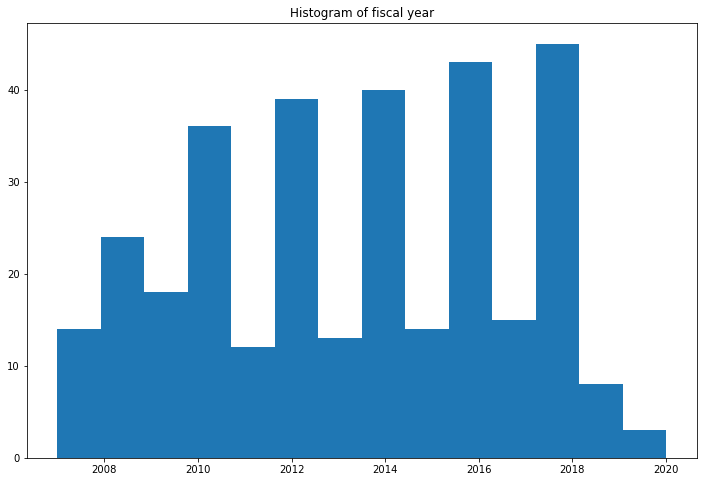

In [33]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.fiscal_year, bins=merged_df.fiscal_year.nunique())
plt.title("Histogram of fiscal year")
plt.show()

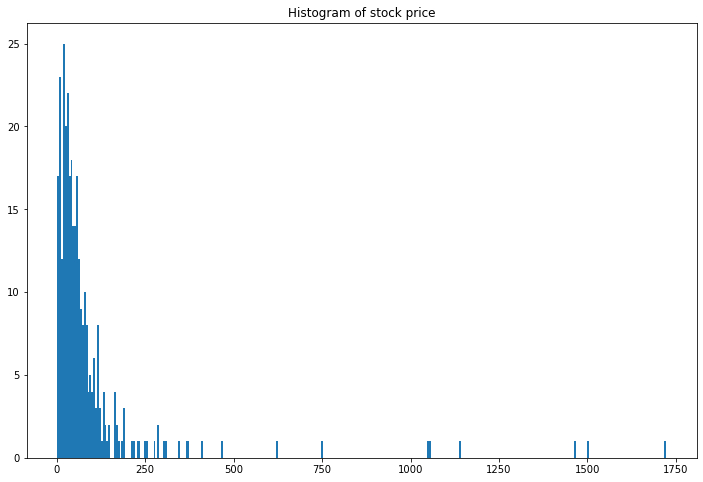

In [34]:
plt.subplots(figsize=(12,8))
plt.hist(merged_df.price, bins=merged_df.price.nunique())
plt.title("Histogram of stock price")
plt.show()

#### It seemed most of the stock prices fall into <= USD 250 bucket. 

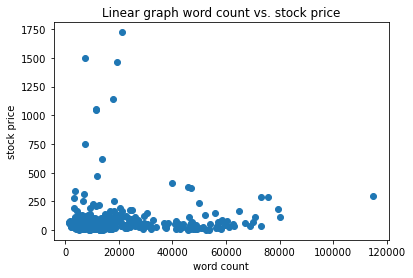

In [35]:
# depicting the visualization
plt.scatter(merged_df.word_count, merged_df.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

#### From the graph above, we couldn't find any obvious correlation between word count and stock prices. 

#### I pulled the companies with stock prices above USD 750 for sanity check. It seemed they were accurate. 

In [36]:
merged_df[merged_df.price > 750]

,cik,symbol,company,fiscal_year,risk,sector,url,price,text,word_count
23,1652044,GOOG,Alphabet Inc. Class C Capital Stock,2017,item 1a.risk factorsour operations and financi...,Communication Services,https://www.sec.gov/Archives/edgar/data/165204...,1046.400024,item 1a.risk factorsour operations and financi...,11405
24,1652044,GOOGL,Alphabet Inc. Class A Common Stock,2017,item 1a.risk factorsour operations and financi...,Communication Services,https://www.sec.gov/Archives/edgar/data/165204...,1053.400024,item 1a.risk factorsour operations and financi...,11405
109,1018724,AMZN,"Amazon.com, Inc. Common Stock",2018,item 1a.risk factorsplease carefully consider ...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/101872...,1501.969971,item 1a.risk factorsplease carefully consider ...,7367
269,1075531,BKNG,Booking Holdings Inc. Common Stock,2018,item 1a. risk factors the following risk fact...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/107553...,1722.420044,item 1a. risk factors the following risk fact...,21340
270,1075531,BKNG,Booking Holdings Inc. Common Stock,2016,item 1a. risk factors the following risk fact...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/107553...,1466.060059,item 1a. risk factors the following risk fact...,19489
271,1075531,BKNG,Booking Holdings Inc. Common Stock,2014,item 1a. risk factors the following risk fac...,Consumer Discretionary,https://www.sec.gov/Archives/edgar/data/107553...,1140.209961,item 1a. risk factors the following risk fac...,17825


#### Next, I removed the duplicates in the data frame based on cik and fiscal_year, and removed outliers with stock prices greater than USD 250. 

In [37]:
data = merged_df.drop_duplicates(subset=['cik', 'fiscal_year'])

In [38]:
data = data[data.price <= 250]

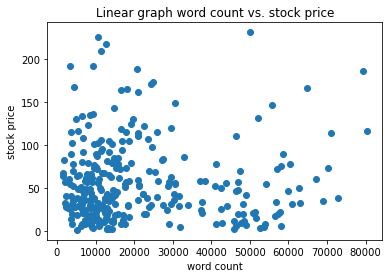

In [39]:
# depicting the visualization after dropping duplicates and outliners 
plt.scatter(data.word_count, data.price) 
plt.xlabel('word count') 
plt.ylabel('stock price') 
plt.title("Linear graph word count vs. stock price")
plt.show() 

#### From this graph, it can be hard to find a correlation between word count and stock price. 

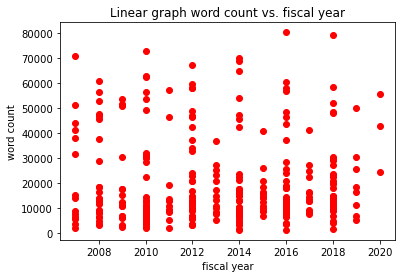

In [40]:
# depicting the visualization
plt.scatter(data.fiscal_year, data.word_count, color="red") 
plt.xlabel('fiscal year') 
plt.ylabel('word count') 
plt.title("Linear graph word count vs. fiscal year")
plt.show() 

#### From the graph above, we couldn't find obvious trend of either decreasing or increasing word count as time goes by. 

### 4. Generate a word cloud based on all the risk text

In [41]:
#convert list to string and generate
all_risks=(" ").join(data.risk)

In [42]:
print(word_count(all_risks))

6314098


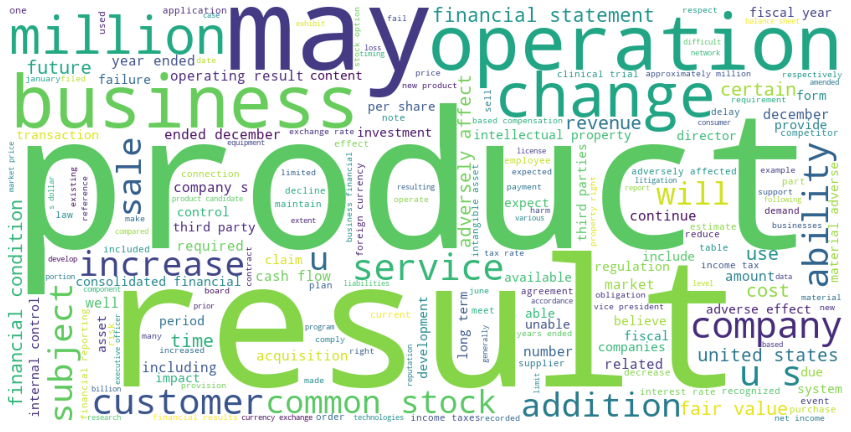

In [43]:
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(all_risks)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wordcloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

### First of all, The word cloud graph showed us that companies most frequently mentioned **product** and **result** in their *Risk Factors* sections in the 10-K reports, which might indicate that they were result-driven business and concentrated on the risks during the development of products -- the core competency of their businesses. 

### Second, **operation**, **change**, **business**, **customer**, **service**, were cued quite a bit across all the 10-K reports in our dataset. While *changes* can be good things, they could also bring in new challenges for business. Meanwhile, *sales*, *customers* and *services* would also greatly impact the financial health of a company, which were mentioned very often. 

### Lastly, we could also spot plenty money related words when companies discussed their risk factors, such as **cash flow**, **financial condition**, **cost**, **revenue**. Other things they were concerned about included **third party**, **intellectual property**, and so on. 

### 5. Save the cleaned data frame

In [44]:
data.to_csv("data.csv", encoding='utf-8', sep=',', header='true')

In [45]:
df = pd.read_csv('data.csv').fillna(value = 0)

### Below are used for debugging 

In [46]:
# cik_ticker = pd.read_csv('nasdaq100_ticker_cik_mapping.csv').fillna(value = 0)

In [47]:
# cik_ticker

In [48]:
# df = pd.merge(df, cik_ticker, how='left', on=['symbol'])

In [49]:
# df.drop('Unnamed: 0', inplace=True, axis=1)

In [50]:
# df.rename(columns = {'company_x':'company'}, inplace = True)
df.head()

,Unnamed: 0,cik,symbol,company,fiscal_year,risk,sector,url,price,text,word_count
0,0,796343,ADBE,Adobe Inc. Common Stock,2018,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,226.240005,"item 1a. risk factorsas previously discussed,...",10522
1,1,796343,ADBE,Adobe Inc. Common Stock,2016,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,102.949997,"item 1a. risk factorsas previously discussed,...",10538
2,2,796343,ADBE,Adobe Inc. Common Stock,2014,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,72.699997,"item 1a. risk factorsas previously discussed,...",10297
3,3,796343,ADBE,Adobe Inc. Common Stock,2012,"item 1a. risk factorsas previously discussed,...",Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,37.680000,"item 1a. risk factorsas previously discussed,...",9580
4,4,796343,ADBE,Adobe Inc. Common Stock,2010,item 1a. risk factors\n \nas previously discu...,Information Technology,https://www.sec.gov/Archives/edgar/data/796343...,30.780001,item 1a. risk factors as previously discuss...,8793


# IV: Text Analysis

## Q1: What are the tones or sentiments used to describe the risks of companies? Are they related to the stock prices?

### 0. Create gold labels

* Create a vector **y_binary** of gold labels for stock prices. 0 stands for below-average stock prices and 1 represents above-average stock prices. 

In [51]:
y_binary = list(map(lambda x : 0 if x < np.mean(data.price) else 1, data['price']))

In [52]:
len(y_binary)

304

In [53]:
sum(y_binary) / len(y_binary)

0.39473684210526316

#### It seemed about 60.5% of the stock prices were below the average, which indicated that there are some high outfliers (a few top performaners which had high stock prcies), which might skew the data. 

### 1. Sentiment Analysis

In [54]:
# Making stopwords list
stoplist = stopwords.words('english')
for el in [i for i in string.punctuation]:
    stoplist.append(el)

In [55]:
emolex_file = os.path.join('emolex.txt')

In [56]:
# read_emolex function from INFO 3350 problem set code

emolex_file = os.path.join('emolex.txt')

def read_emolex(filepath=None):
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = os.path.join('emolex.txt')
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [57]:
# Get EmoLex df. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [58]:
def getSentScore(sentence_dicts, df, index):
    
    bookdict = dict({'anger': 0 , 'anticipation': 0,'disgust': 0,'fear': 0,'joy': 0,'negative': 0,'positive': 0,'sadness': 0,'surprise': 0, 'trust': 0})
    
    for sentence_dict in sentence_dicts:
        for emotion in sentence_dict:
            bookdict[emotion] += sentence_dict[emotion]
    
    for emotion in bookdict.keys():
        bookdict[emotion] /= len(sentence_dicts)
        df.at[index, emotion] = bookdict[emotion]
    
    return None  

In [59]:
def tokenize_text(text, stops=[]):
    sentences = []
    for sent in sent_tokenize(text.lower()):
        sentences.append([word for word in word_tokenize(sent) if word not in stops])
        
    return sentences

In [60]:
# sentence_sentiment_score from INFO 3350 problem set code
def sentence_sentiment_score(toks, lexicon = emolex):
    total = 0
    emo_dict = defaultdict(lambda: 0)
    
    emotions = ['anger', 'anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']
    
    
    for word in toks:
        total += 1
        for emotion in emotions:
            try:
                emo_dict[emotion] += lexicon[word][emotion]
            except:
                continue
    
    for emotion in emotions:
        if total > 0:
            emo_dict[emotion] /= total
        
    return emo_dict

In [61]:
#### Adding sentiment score columns
size = len(df)

df['anger'] = np.zeros(size)
df['anticipation'] = np.zeros(size)
df['disgust'] = np.zeros(size)
df['fear'] = np.zeros(size)
df['joy'] = np.zeros(size)
df['negative'] = np.zeros(size)
df['positive'] = np.zeros(size)
df['sadness'] = np.zeros(size)
df['surprise'] = np.zeros(size)
df['trust'] = np.zeros(size)

In [62]:
len(df)

304

In [63]:
%%time

for index, text in enumerate(df['risk']):
    sentence_dicts = []
    for sentence in tokenize_text(text, stops=stoplist):
        sentence_dicts.append(sentence_sentiment_score(sentence))
    getSentScore(sentence_dicts, df, index)

CPU times: user 1min 18s, sys: 1.27 s, total: 1min 19s
Wall time: 1min 21s


In [64]:
df.tail()

,Unnamed: 0,cik,symbol,company,fiscal_year,risk,sector,url,price,text,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
299,320,900075,CPRT,"Copart, Inc. (DE) Common Stock",2016,item 1a. risk factorsinvesting in our commo...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,27.705000,item 1a. risk factorsinvesting in our commo...,...,0.019701,0.038329,0.016762,0.030321,0.009661,0.066185,0.094219,0.023611,0.008625,0.052095
300,321,900075,CPRT,"Copart, Inc. (DE) Common Stock",2014,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.245001,item 1a. risk factors investing in our co...,...,0.023981,0.037899,0.019341,0.033534,0.010873,0.066368,0.096863,0.026728,0.007782,0.053089
301,322,900075,CPRT,"Copart, Inc. (DE) Common Stock",2013,item 1a.\n \nrisk factors\n\n\n\ninvesting in ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,18.325001,item 1a. risk factors investing in our co...,...,0.024179,0.039362,0.020800,0.036514,0.010880,0.067244,0.098653,0.028181,0.007672,0.053146
302,323,900075,CPRT,"Copart, Inc. (DE) Common Stock",2010,item 1a. risk factors \n investing ...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,9.337500,item 1a. risk factors investing i...,...,0.023554,0.040803,0.019069,0.033254,0.010905,0.065662,0.104372,0.025967,0.006681,0.050782
303,324,900075,CPRT,"Copart, Inc. (DE) Common Stock",2009,item 1a. risk factors \n investi...,Industrials,https://www.sec.gov/Archives/edgar/data/900075...,9.155000,item 1a. risk factors investin...,...,0.024608,0.038114,0.019443,0.033097,0.011708,0.066980,0.103876,0.026330,0.005692,0.049739


In [65]:
df.describe()

,Unnamed: 0,cik,fiscal_year,price,word_count,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
count,304.000000,3.040000e+02,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,160.911184,8.834649e+05,2013.154605,55.872967,20770.375000,0.017637,0.041907,0.009962,0.027525,0.018901,0.059696,0.105277,0.023928,0.009313,0.059365
std,94.628030,3.874983e+05,3.549617,45.485301,17656.526626,0.004749,0.006466,0.003954,0.006934,0.004922,0.011735,0.009175,0.005281,0.003183,0.008030
min,0.000000,2.488000e+03,2007.000000,1.630000,1423.000000,0.007411,0.027373,0.001337,0.011841,0.005467,0.034340,0.081583,0.012612,0.003284,0.039743
25%,77.750000,7.693970e+05,2010.000000,22.351250,8559.500000,0.014453,0.037874,0.007385,0.021839,0.016099,0.050279,0.099411,0.020588,0.007238,0.054046
50%,162.500000,8.911030e+05,2013.000000,43.465000,13549.000000,0.017320,0.042030,0.009856,0.028327,0.018006,0.060357,0.105674,0.023531,0.008982,0.058147
75%,240.250000,1.094455e+06,2016.000000,74.807501,27734.750000,0.020033,0.044576,0.012538,0.032216,0.020773,0.067393,0.111322,0.027425,0.010611,0.063793
max,324.000000,1.811210e+06,2020.000000,231.669998,80342.000000,0.041867,0.069143,0.027367,0.050213,0.037843,0.093268,0.130600,0.042139,0.021311,0.086329


#### Visualize the sentiment analysis

In [66]:
# from INFO 3350 problem set
def visualize_emotion_scores(scores, cols, xLabel):
    df = pd.DataFrame.from_dict(scores)
    values = df.columns
    df = df.reset_index().melt(id_vars='index', value_vars=values, var_name='emotion').rename(columns={'index':xLabel})
    sns.set_context('poster')
    g = sns.catplot(x=xLabel, y='value', col='emotion', data=df, kind='bar', col_wrap=cols)
    g.set_xticklabels(rotation = 90, fontsize=10)
    return g

In [67]:
grouped_sent = df.groupby(y_binary).mean()\
[['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']]

print("Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in \
the corpus. \n\
'True' indicates detective novels.")

grouped_sent

Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in the corpus. 
'True' indicates detective novels.


,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0.017662,0.041922,0.010006,0.027683,0.018833,0.059660,0.104365,0.02416,0.009218,0.058108
1,0.017599,0.041885,0.009894,0.027282,0.019003,0.059752,0.106675,0.02357,0.009458,0.061293


In [68]:
sent_dict = grouped_sent.to_dict()

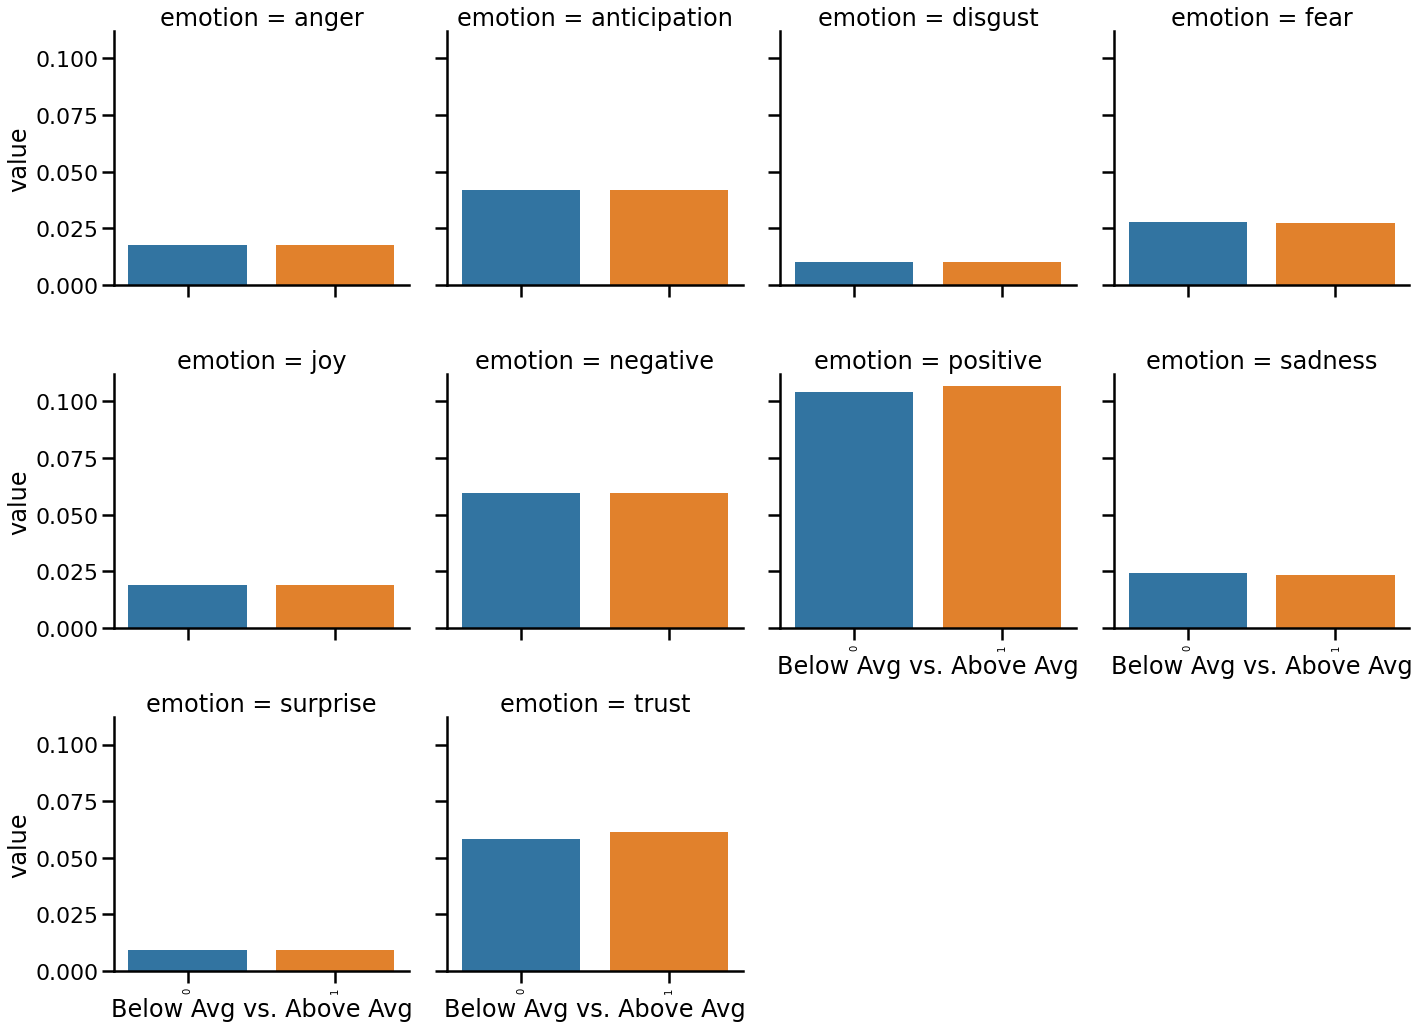

In [69]:
visualize_emotion_scores(sent_dict, 4, 'Below Avg vs. Above Avg')

#### (1) Acorss all the emotions, it seemed those publicly traded companies tended to use **positive** tones in their writings of the Risk Factors section no matter what their stock performances were, compared to any other emotions. 

#### (2) The emotion **surprise** is the least mentioned in the Risk Factors section. It seemed those companies used caution when publishing their 10-K annual reports, trying not to deliver any surprising messages to scare them away. 

#### (3) Comparing the emotion scores by stock price, there did not appear to be any significant differences between below-average and above-average stock prices.

#### Sentiment analysis by sector

In [70]:
sent_sector = df.groupby(df.sector).mean()\
[['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']]

print("Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in \
the corpus. \n\
'True' indicates detective novels.")

sent_sector

Average detective novel sentiment scores in comparison to average sentiment scores of all other genres in the corpus. 
'True' indicates detective novels.


,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
sector,,,,,,,,,,
Communication Services,0.017907,0.046434,0.010235,0.025370,0.023546,0.057030,0.103963,0.024235,0.012803,0.061518
Consumer Discretionary,0.020141,0.046028,0.011358,0.028109,0.023078,0.061278,0.108391,0.025355,0.012028,0.063059
Consumer Staples,0.017539,0.040549,0.011603,0.027445,0.019326,0.063433,0.108508,0.026673,0.008911,0.055298
Health Care,0.014626,0.040880,0.009368,0.029830,0.016184,0.058529,0.105661,0.021307,0.008196,0.056657
Industrials,0.018230,0.040832,0.010050,0.029187,0.016170,0.060518,0.104939,0.024201,0.006625,0.058790
Information Technology,0.018013,0.040952,0.009614,0.026815,0.018270,0.060279,0.104971,0.024352,0.008752,0.060054
Utilities,0.012886,0.030101,0.007581,0.026168,0.015492,0.046936,0.091092,0.015416,0.009377,0.044091


In [71]:
sent_sec_dict = sent_sector.to_dict()

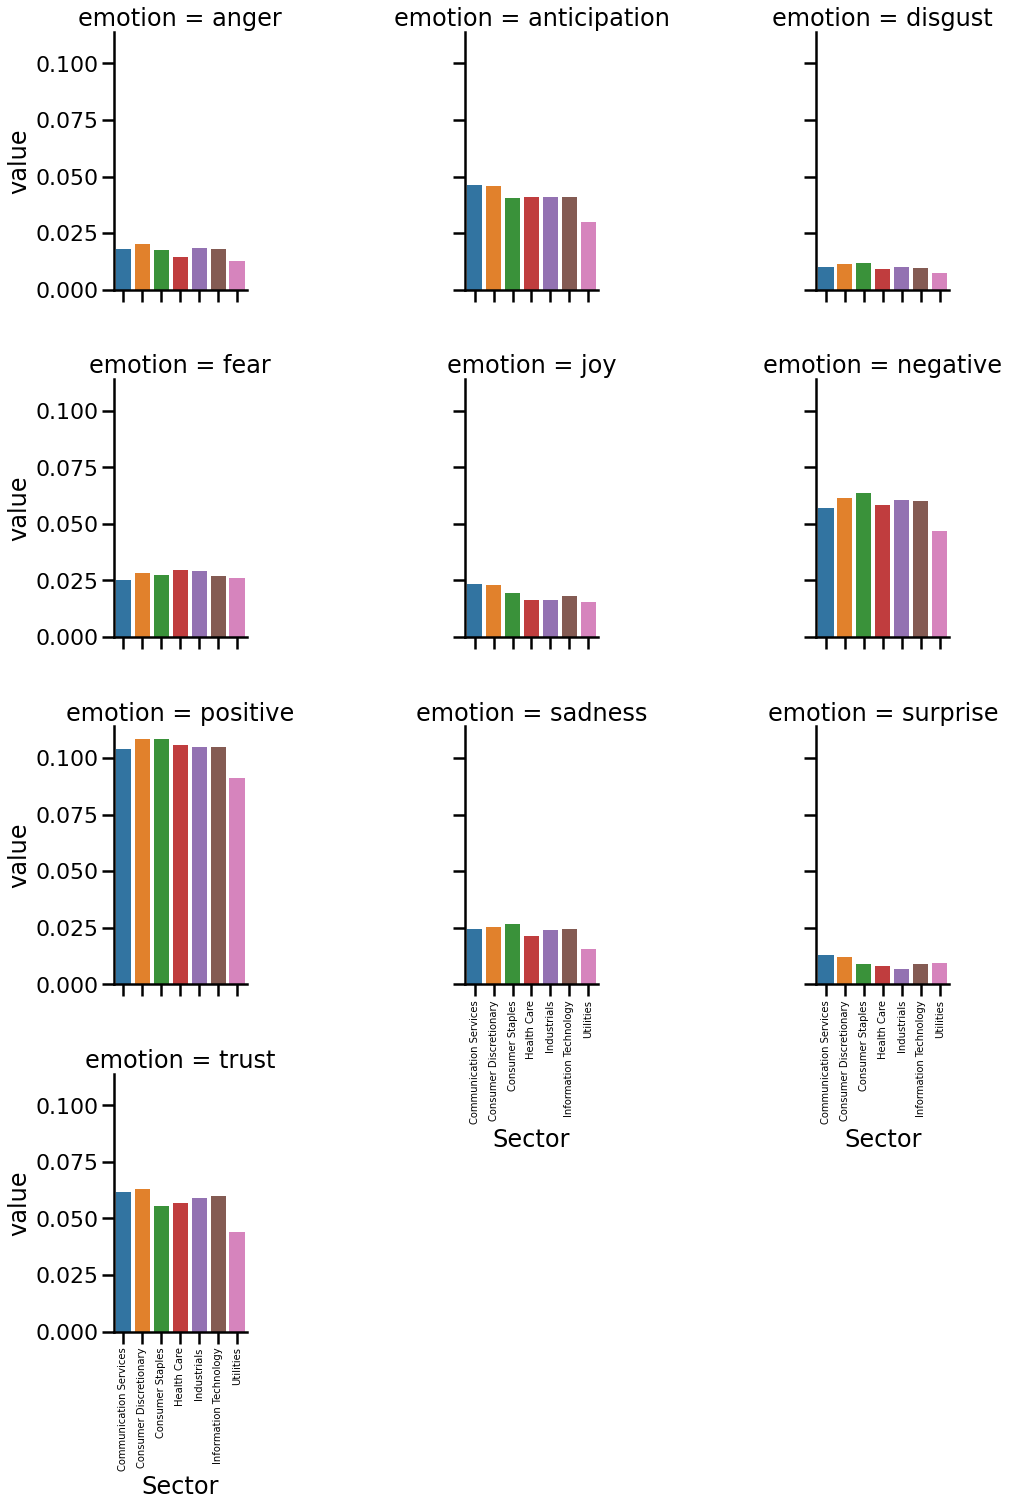

In [72]:
visualize_emotion_scores(sent_sec_dict, 3, 'Sector')

#### Looking at the mean sentiment scores by sector, we could get some interesting findings. 

#### (1) The sector **Utilities** appeared to have the lowest mean sentiment scores among any other sectors, except for the *surprise* emotion. 

#### (2) The **Consumer Discretionary** sector would like to deliver *anticipation*, *positivity* and *trust* emotions to their audience in their Risk Factors sections. 

#### (3) The **Consumer Statples** sector showed slightly more worries regarding the risks in their 10-K reports and ranked the highest in *sadness* and *negative* emotion categories. 

#### 1-2-0 Create Vectorizer

In [73]:
# Vectorize
vectorizer = TfidfVectorizer(
    encoding = 'utf-8',
    strip_accents = 'unicode',
    lowercase = True,
    min_df = 0.01,
    max_df = 0.9,
    use_idf=True,
    token_pattern=r'(?u)\b[A-Za-z]+\b'
)

In [74]:
# perform vectorization
X = vectorizer.fit_transform(df.risk.values.astype('U'))
print("Shape of the feature matrix", X.shape)

Shape of the feature matrix (304, 11309)


In [75]:
# standard-scale feature matrix
X = StandardScaler().fit_transform(X.todense())

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


### 2. Clustering

In [76]:
############## code from INFO 6350 problem set code ##############
def plot_compare(X, labels, title, reduce=True, alpha=0.2):
    '''
    Takes an array of object data, a set of cluster labels, and a title string
    Reduces dimensions to 2 and plots the clustering.
    Returns nothing.
    '''
    
    if reduce:
        # TruncatedSVD is fast and can handle sparse inputs
        # PCA requires dense inputs; MDS is slow
        coordinates = TruncatedSVD(n_components=2).fit_transform(X)
    else:
        # Optionally handle 2-D inputs
        coordinates = X
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12,6))

    # Unlabeled data
    plt.subplot(121) # 1x2 plot, position 1
    plt.scatter(
        coordinates[:, 0], 
        coordinates[:, 1], 
        alpha=alpha, # Set transparency so that we can see overlapping points
        linewidths=0 # Get rid of marker outlines
    )
    plt.title("Unclustered data")

    # Labeled data
    plt.subplot(122)
    sns.scatterplot(
        x=coordinates[:, 0], 
        y=coordinates[:, 1],
        hue=labels,
        alpha=alpha,
        palette='viridis',
        linewidth=0
    )
    plt.title(title)
    plt.show()

In [77]:
############## code from INFO 6350 problem set code ##############
def pull_samples(texts, labels, n=3):
    '''
    Takes lists of texts and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    texts_array = np.array(texts) # Make the input text list easily addressable by NumPy
    for label in np.unique(labels): # Iterate over labels
        print("Label:", label)
        sample_index = np.where(labels == label)[0] # Limit selection to current label
        print("Number of texts in this cluster:", len(sample_index), '\n')
        chosen = np.random.choice(sample_index, size=n) # Sample n texts with this label
        for choice in chosen:
            print("Sample text:", choice)
            # print(str(texts_array[choice]).split(" 0")[0], '\n') # Print each sampled text
            print(str(texts_array[choice])[1:80]) # Print each sampled text
            print("fiscal year: ", texts.fiscal_year[choice])
            print("company: ", texts.company[choice])
            print("word count: ", texts.word_count[choice])
            print("sector: ", texts.sector[choice])
            print(texts.url[choice], '\n')
        print("###################################")

Label vector shape:  (304,)
Using KMeans clustering with n=2 clusters; we are assuming that the clusters are detective and non-detective novels.


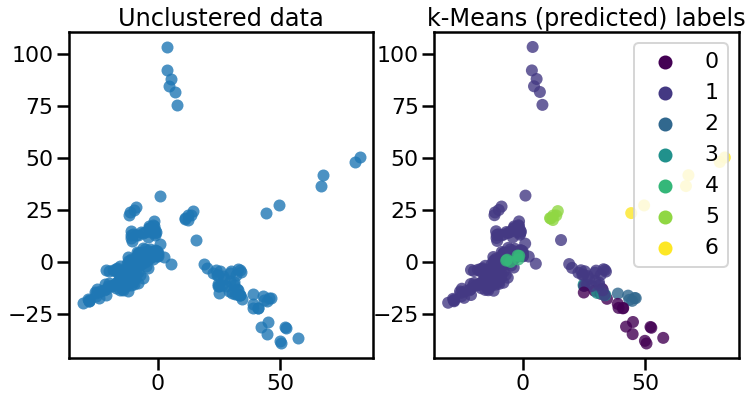

In [78]:
y_kmeans = KMeans(n_clusters=7).fit_predict(X) # this output is the cluster labels

# Print label vector shape
print('Label vector shape: ', y_kmeans.shape)

print("Using KMeans clustering with n=2 clusters; we are assuming that the clusters are detective and non-detective novels.")

# Plot results
plot_compare(X, y_kmeans, 'k-Means (predicted) labels', reduce=True, alpha=0.8)

In [79]:
pull_samples(df, y_kmeans, 3)

Label: 0
Number of texts in this cluster: 17 

Sample text: 248
261 827054 'MCHP' 'Microchip Technology Incorporated Common Stock' 2008
 "item 
fiscal year:  2008
company:  Microchip Technology Incorporated Common Stock
word count:  47703
sector:  Information Technology
https://www.sec.gov/Archives/edgar/data/827054/000082705408000120/form10-k.htm 

Sample text: 95
97 1013462 'ANSS' 'ANSYS, Inc. Common Stock' 2009
 'item 1a.  acquisitions  on 
fiscal year:  2009
company:  ANSYS, Inc. Common Stock
word count:  30417
sector:  Information Technology
https://www.sec.gov/Archives/edgar/data/1013462/000119312510040617/d10k.htm 

Sample text: 73
75 1058290 'CTSH'
 'Cognizant Technology Solutions Corporation Class A Common S
fiscal year:  2016
company:  Cognizant Technology Solutions Corporation Class A Common Stock
word count:  43836
sector:  Information Technology
https://www.sec.gov/Archives/edgar/data/1058290/000105829017000008/ctsh20161231-10k.htm 

###################################
Lab

#### From the samples pulled from each cluster, it seemed the label 0 cluster captured the longer risk reports (> 25000 words), whereas the label 1 cluster had much shorter risk reports in length. It may be worth testing this finding by using the word count to construct a linear regression model in Q3. 

In [80]:
df.groupby('sector').agg({'word_count':['mean','count']})

word_count      
                                mean count
sector                                    
Communication Services  17964.441176    34
Consumer Discretionary  20019.166667    36
Consumer Staples        11442.187500    16
Health Care             27873.934783    46
Industrials             22655.129032    31
Information Technology  19247.503704   135
Utilities               36119.166667     6

In [81]:
df.groupby('sector').agg({'price':['mean','count']})

price      
                             mean count
sector                                 
Communication Services  46.934595    34
Consumer Discretionary  79.782885    36
Consumer Staples        63.945626    16
Health Care             64.014348    46
Industrials             50.418908    31
Information Technology  50.322752   135
Utilities               32.179030     6

## Q2. Can we build classifier to categorize the IT sector and non-IT sector by their Risk Factors? If so, what features are most important? 

In [89]:
# Examine the performance of our simple classifiers
# Freebie function to summarize and display classifier scores
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [82]:
y_it = list(map(lambda x : 0 if x == 'Information Technology' else 1, df['sector']))

In [83]:
sum(y_it)/len(y_it)

0.555921052631579

In [130]:
selector_k = SelectKBest(score_func=mutual_info_regression, k=20)

# Print the shape of your new feature matrix
X_token_k_it = selector_k.fit_transform(X, y_it)
print("Shape of the matrix with 20 selected features: ", X_token_k_it.shape)

Shape of the matrix with 20 selected features:  (304, 20)


In [85]:
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LogisticRegression(), X_token_k_it, y_it, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.8491397849462364


In [86]:
%%time
print("Random Forest === Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(RandomForestClassifier(max_features="auto"), X_token_k_it, y_it, scoring='accuracy', cv=10)))

Random Forest === Mean cross-validated accuracy scores: 0.888709677419355
CPU times: user 1.79 s, sys: 43.1 ms, total: 1.84 s
Wall time: 1.3 s


In [87]:
%%time
print("Decision Tree === Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(DecisionTreeClassifier(max_depth=100), X_token_k_it, y_it, scoring='accuracy', cv=10)))

Decision Tree === Mean cross-validated accuracy scores: 0.8384946236559141
CPU times: user 26.3 ms, sys: 2.41 ms, total: 28.7 ms
Wall time: 50.1 ms


In [90]:
classifiers = {
    'decisionTreeNone': DecisionTreeClassifier(max_depth=None),
    'decisionTree5': DecisionTreeClassifier(max_depth=5),
    'decisionTree7': DecisionTreeClassifier(max_depth=7),
    'decisionTree10': DecisionTreeClassifier(max_depth=10),
    'decisionTree25': DecisionTreeClassifier(max_depth=25),
    'decisionTree50': DecisionTreeClassifier(max_depth=50),
    
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_token_k_it, # feature matrix
        y_it, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
decisionTreeNone,0.002339,0.005418,0.812473,0.829736,0.852941,0.826815,0.804499,0.812473
decisionTree5,0.001663,0.003895,0.832151,0.846931,0.870588,0.845259,0.825237,0.832151
decisionTree7,0.001400,0.003276,0.832366,0.853257,0.858824,0.845548,0.825692,0.832366
decisionTree10,0.001279,0.003176,0.818817,0.838408,0.864706,0.839709,0.811183,0.818817
decisionTree25,0.001427,0.003247,0.835591,0.867247,0.847059,0.844445,0.829988,0.835591
decisionTree50,0.001366,0.003551,0.855269,0.877664,0.882353,0.868641,0.849559,0.855269


In [91]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        X_token_k_it, # feature matrix
        y_it, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,0.150362,0.011997,0.869462,0.918115,0.841176,0.870365,0.867825,0.869462
feature_100,0.123438,0.011735,0.869140,0.919298,0.841176,0.872273,0.867826,0.869140
feature_5,0.103600,0.011107,0.869247,0.904614,0.852941,0.871000,0.867702,0.869247
feature_2,0.095750,0.011320,0.901828,0.923576,0.905882,0.909904,0.900326,0.901828
est_og,0.109726,0.012120,0.878925,0.922302,0.852941,0.879740,0.877515,0.878925


In [131]:
feature_names = vectorizer.get_feature_names()
feature_names_ = [feature_names[i] for i in selector_k.get_support(indices=True)]

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [132]:
feature_names_

['category',
 'collective',
 'commodities',
 'drug',
 'food',
 'insurers',
 'interstate',
 'medicare',
 'merchandise',
 'miles',
 'patient',
 'patients',
 'preclinical',
 'repurchased',
 'residential',
 'square',
 'studies',
 'therapies',
 'treatments',
 'warning']

## Q3: Can we build a classifier to categorize the below-average-stock-price and above-average-stock-price by their Risk Factors from 10-K reports? What are the most important features to distinguish them? Can we improve the accuracy of our classifiers? 

### 1. Build a token-based classifier

In [92]:
%%time
# Select best features
selector = SelectKBest(score_func=mutual_info_regression, k=50)

# Print the shape of your new feature matrix
X_top = selector.fit_transform(X, y_binary)
print("Shape of the combined matrix with 300 selected features: ", X_top.shape)

Shape of the combined matrix with 300 selected features:  (304, 50)
CPU times: user 19.1 s, sys: 214 ms, total: 19.3 s
Wall time: 19.5 s


In [93]:
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LogisticRegression(), X_top, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.6005376344086021


In [94]:
feature_names = vectorizer.get_feature_names()
feature_names_ = [feature_names[i] for i in selector.get_support(indices=True)]

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:
feature_names_

['assign',
 'banking',
 'binds',
 'bridgeport',
 'cancellation',
 'cardiac',
 'com',
 'compatible',
 'completely',
 'contentsprolonged',
 'contracting',
 'cosmetic',
 'declare',
 'digitally',
 'disagreement',
 'diverted',
 'downs',
 'drugs',
 'elon',
 'enacted',
 'eu',
 'game',
 'generations',
 'generic',
 'genzyme',
 'glossary',
 'hyperlinks',
 'impacting',
 'interrupt',
 'jonathan',
 'lithium',
 'lowers',
 'lucrative',
 'monitoring',
 'mounted',
 'nols',
 'ofperiod',
 'pass',
 'prohibition',
 'proposals',
 'prudent',
 'radiometer',
 'red',
 'responses',
 'restrictive',
 'seamlessly',
 'standards',
 'stored',
 'swaps',
 'unite']

#### 1-2. Improve token-based classifier

##### Feature Engineering

In [133]:
selector_k = SelectKBest(score_func=mutual_info_regression, k=100)

In [137]:
# Print the shape of your new feature matrix
X_token_k = selector_k.fit_transform(X, y_binary)
print("Shape of the matrix with 100 selected features: ", X_token_k.shape)

Shape of the matrix with 100 selected features:  (304, 100)


In [106]:
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LogisticRegression(), X_token_k, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5182795698924731


In [136]:
%%time
print("Random Forest === Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(RandomForestClassifier(max_features="auto"), X_token_k, y_binary, scoring='accuracy', cv=10)))

Random Forest === Mean cross-validated accuracy scores: 0.6175268817204301
CPU times: user 1.3 s, sys: 25 ms, total: 1.32 s
Wall time: 1.34 s


In [108]:
%%time
print("Decision Tree === Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(DecisionTreeClassifier(max_depth=100), X_token_k, y_binary, scoring='accuracy', cv=10)))

Decision Tree === Mean cross-validated accuracy scores: 0.5879569892473118
CPU times: user 18.4 ms, sys: 2.21 ms, total: 20.6 ms
Wall time: 19 ms


##### Try out different parameters

In [109]:
classifiers = {
    'decisionTreeNone': DecisionTreeClassifier(max_depth=None),
    'decisionTree5': DecisionTreeClassifier(max_depth=5),
    'decisionTree7': DecisionTreeClassifier(max_depth=7),
    'decisionTree10': DecisionTreeClassifier(max_depth=10),
    'decisionTree25': DecisionTreeClassifier(max_depth=25),
    'decisionTree50': DecisionTreeClassifier(max_depth=50),
    
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_token_k, # feature matrix
        y_binary, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

compare_scores(scores)

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
decisionTreeNone,0.001106,0.003458,0.587957,0.478694,0.566667,0.510887,0.574248,0.587957
decisionTree5,0.000811,0.004067,0.634624,0.525694,0.333333,0.374750,0.554858,0.634624
decisionTree7,0.000966,0.003508,0.647957,0.559127,0.391667,0.440033,0.589581,0.647957
decisionTree10,0.001009,0.003395,0.641290,0.558846,0.400000,0.445007,0.587322,0.641290
decisionTree25,0.000980,0.003231,0.607634,0.490567,0.608333,0.535729,0.594490,0.607634
decisionTree50,0.000960,0.003183,0.601183,0.487650,0.600000,0.530690,0.588653,0.601183


In [138]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        X_token_k, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,0.209942,0.016733,0.592043,0.516548,0.416667,0.433968,0.550275,0.592043
feature_100,0.116963,0.012295,0.617742,0.555476,0.358333,0.420536,0.564225,0.617742
feature_5,0.116782,0.012846,0.634624,0.590952,0.341667,0.411446,0.569450,0.634624
feature_2,0.111504,0.012388,0.657204,0.695159,0.308333,0.412580,0.583970,0.657204
est_og,0.113691,0.011952,0.621613,0.551400,0.400000,0.451971,0.579157,0.621613


#### It looks like Random Forest classifier had a better accuracy score on token-based feature matrix, but decision tree classifier had a better F1 score. 

### 2. Build a word-embedding-based classifier

In [96]:
def get_doc_embedding(doc, nlp):    
    # remove_noninformative_tokens
    tokens = nlp(doc)
    culled = []
    culled = [token for token in tokens if not (token.is_stop or token.is_punct or token.is_space) and token.has_vector]
    '''
    Takes two lists of spacy token objects.
    Returns cosine similarity between their embedding representations.
    '''
    mean_vector_culled = np.mean([token.vector for token in culled], axis=0)
       
    return mean_vector_culled

In [97]:
nlp = spacy.load("en_core_web_lg") # Note '_lg' = large model

In [98]:
%%time
X_embedding = []
X_embedding = np.zeros((len(df.risk), nlp.vocab.vectors_length))

for i, content in enumerate(df.risk):
    X_embedding[i] = get_doc_embedding(content, nlp)  

CPU times: user 19min 34s, sys: 2min 32s, total: 22min 7s
Wall time: 22min 35s


In [99]:
print("Shape of embedding matrix: ", X_embedding.shape)

Shape of embedding matrix:  (304, 300)


In [100]:
# standard-scale feature matrix
X_embedding = StandardScaler().fit_transform(X_embedding)

In [101]:
# Calculate a 10-fold cross-validated accuracy score using a logistic regression classifier on your selected feature df.
# Cross-validate the logistic regression classifier on full input data

print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LogisticRegression(max_iter=500), X_embedding, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5623655913978494


#### 2-2. Improve embedding-token-based classifier

##### Try SVM classifier
* linear SVM 
* non-linear SVM

In [143]:
%%time
from sklearn.svm import LinearSVC
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(LinearSVC(max_iter=10000), X_embedding, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5688172043010753
CPU times: user 3.34 s, sys: 6.48 ms, total: 3.35 s
Wall time: 3.35 s


In [111]:
%%time
print("Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(SVC(), X_embedding, y_binary, scoring='accuracy', cv=10)))

Mean cross-validated accuracy scores: 0.5116129032258063
CPU times: user 86.7 ms, sys: 4.8 ms, total: 91.5 ms
Wall time: 95 ms


In [112]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        X_embedding, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,2.421274,0.014408,0.548710,0.366279,0.316667,0.316482,0.479680,0.548710
feature_100,0.187704,0.013462,0.528602,0.347921,0.316667,0.317389,0.473004,0.528602
feature_5,0.168515,0.015237,0.538280,0.352273,0.266667,0.281662,0.464760,0.538280
feature_2,0.245263,0.022261,0.538065,0.368860,0.275000,0.303778,0.475528,0.538065
est_og,0.312261,0.017818,0.531505,0.362035,0.308333,0.310968,0.471975,0.531505


### 3. Can named entities feature matrix improve the classifier? 

In [113]:
# Count entities and POS tags
valid_ent = ['PERSON', 'MONEY', 'TIME']
valid_pos = ['ADJ', 'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'PRON', 'PROPN', 'VERB']

In [114]:
%%time

text_data = []
for text in df.risk:
    counts = Counter()
    doc = nlp(text)
    # counts['wordcount'] = len(doc) #
    for entity in doc.ents:
        if entity.label_ in valid_ent:
            counts[entity.label_] += 1
    for token in doc:
        if token.pos_ in valid_pos:
            counts[token.pos_] += 1
    text_data.append(counts)

CPU times: user 20min 20s, sys: 2min 33s, total: 22min 53s
Wall time: 23min 22s


In [115]:
sum_ent = {}

In [116]:
for item in text_data:
    for key, val in item.items():
        if sum_ent.get(key) == None:
            sum_ent.update({key : 0})
        sum_ent[key] += val

In [117]:
sum_ent

{'TIME': 304,
 'PERSON': 5728,
 'MONEY': 29550,
 'NOUN': 1734963,
 'ADV': 130383,
 'VERB': 591675,
 'PRON': 309830,
 'ADJ': 563066,
 'AUX': 237637,
 'DET': 375045,
 'CCONJ': 314456,
 'PROPN': 185929}

<BarContainer object of 12 artists>

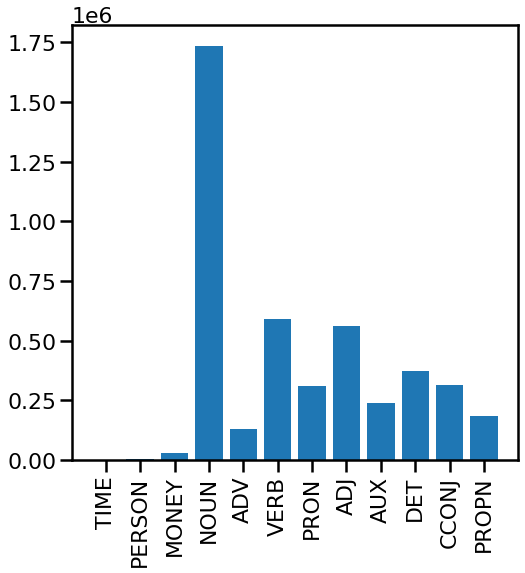

In [118]:
names, counts = zip(*sum_ent.items())
fig, ax = plt.subplots(figsize=(8,8))
plt.xticks(rotation=90)
plt.bar(names, counts)

#### Unsurprisingly, **MONEY** was mentioned the most among the three entities: **TIME**, **PERSOM**, and **MONEY**, since the dataset was derived from the annual financial reports. Nevertheless, **NOUN**s appeared the most among all the other entities. 

In [119]:
# Vectorize entitiy and POS counts
vectorizer = DictVectorizer(sparse=False)
X_trans = vectorizer.fit_transform(text_data)
print("Shape of the transformed matrix: ", X_trans.shape)

Shape of the transformed matrix:  (304, 12)


In [120]:
# Scale
# Standard-scale your feature matrix
X_trans = StandardScaler().fit_transform(X_trans)
print("Shape of the scaled matrix: ", X_trans.shape)

Shape of the scaled matrix:  (304, 12)


In [121]:
%%time
print("Random Forest === Mean cross-validated accuracy scores:", 
      np.mean(cross_val_score(RandomForestClassifier(max_features="auto"), X_trans, y_binary, scoring='accuracy', cv=10)))

Random Forest === Mean cross-validated accuracy scores: 0.5548387096774194
CPU times: user 1.4 s, sys: 26.3 ms, total: 1.43 s
Wall time: 1.45 s


In [144]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        X_trans, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,0.179861,0.013041,0.535269,0.376440,0.333333,0.348578,0.492088,0.535269
feature_100,0.158806,0.011717,0.535269,0.385707,0.308333,0.327383,0.483209,0.535269
feature_5,0.125196,0.011209,0.521613,0.373600,0.283333,0.304401,0.466778,0.521613
feature_2,0.114214,0.012140,0.561398,0.435126,0.291667,0.339211,0.503714,0.561398
est_og,0.118590,0.011739,0.557957,0.391496,0.283333,0.311513,0.490269,0.557957


### 4. Build Topic Modeling feature matrix

In [122]:
# Vectorize
vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english', # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25,    # Ditto
    token_pattern=r'(?u)\b[A-Za-z]+\b'
)

X = vectorizer.fit_transform(df.risk)
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized paragraph length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (304, 19948)
Total vectorized words in the corpus: 477270
Average vectorized paragraph length: 1569 tokens


In [123]:
%%time
lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 902 ms, sys: 890 ms, total: 1.79 s
Wall time: 5.46 s


LatentDirichletAllocation(evaluate_every=0, n_components=20, n_jobs=-1,
                          verbose=1)

In [124]:
# Print top words per topic

def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
            for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [145]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: debentures domain hotel semiconductor icann registry hotels wafer gtlds windows
Topic  1: csx rail csxt pension millions track exhibit registrant freight cars
Topic  2: developers resellers cintas satellite outsourcing stores satellites apple subscribers suites
Topic  3: charter cco video games cable entertainment programming game developers facebook
Topic  4: clinical fda trials gilead glucose registrant trial sciences patients commercialization
Topic  5: micron inotera mmj semiconductor memory dated dram flash intel nand
Topic  6: thousands exhibit weighted unrealized sfas vesting dated semiconductor amortized indian
Topic  7: cisco iac mr search ip eda google video collaboration listings
Topic  8: stores vehicle merchandise electric hosts tesla guests battery tree warrants
Topic  9: flash intel memory semiconductor dram numonyx micron dated inotera tech
Topic 10: food beverage water ingredients snack foods bottlers commodities consumption kraft
Topic 11: nvidia subscriptio

In [126]:
# Create a doc-topic matrix
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (304, 20)


In [148]:
# trying diff max_features
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_100':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=5),
    'feature_2':RandomForestClassifier(max_features=2),
    'est_og':RandomForestClassifier()
}

RFscores1 = {} 
for classifier in RFfeatures:
    RFscores1[classifier] = cross_validate( 
        RFfeatures[classifier], 
        X_topics, # feature matrix
        y_binary, # gold labels
        cv=10, 
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] 
    )

compare_scores(RFscores1)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
feature_None,0.262269,0.012314,0.422688,0.284346,0.250000,0.243202,0.376872,0.422688
feature_100,0.179211,0.012465,0.415914,0.293578,0.258333,0.254494,0.376479,0.415914
feature_5,0.134059,0.011950,0.419032,0.307099,0.250000,0.251421,0.379627,0.419032
feature_2,0.112213,0.011548,0.432796,0.282939,0.216667,0.230464,0.383084,0.432796
est_og,0.128541,0.012179,0.455699,0.339620,0.275000,0.279378,0.413379,0.455699


In [149]:
pyLDAvis.enable_notebook()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_vis = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='pcoa', sort_topics=False)
pyLDAvis.display(lda_vis)

/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/annzhou/opt/anaconda3/lib/python3.9/site-packages/past/builti

# Part 4: Results and Discussion

# Part 5: Reflection

# Part 6: References

* https://stackoverflow.com/questions/48687857/python-json-list-to-pandas-dataframe

* https://www.youtube.com/watch?v=fw4gK-leExw&ab_channel=IzzyAnalytics

* https://en.wikipedia.org/wiki/Nasdaq-100

# Part 7: Responsibility Statement

I completed this project on my own. 